In [9]:
import tensorflow as tf
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

In [2]:
 import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-02-19 15:52:34.472655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 15:52:34.476849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 15:52:34.476944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 15:52:34.478308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [7]:
width_size = 512
height_size = 512

In [4]:
def define_custom_model(classes=4):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(width_size, height_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(classes, activation='softmax')
    ])
    
    return model

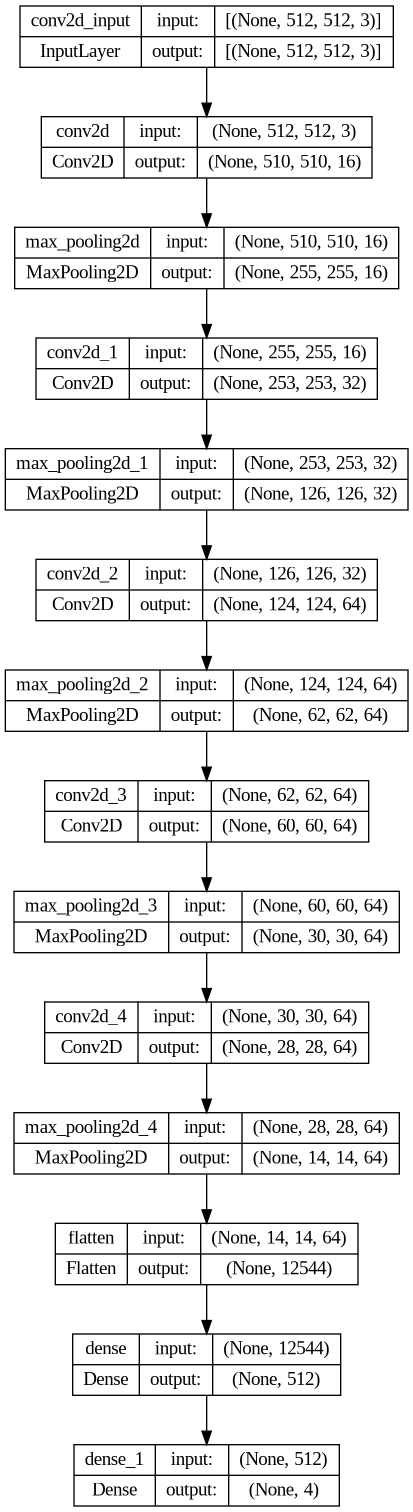

In [5]:
from tensorflow.keras.utils import plot_model

model = define_custom_model()
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models

def vgg16(classes=4):
    
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(width_size, height_size, 3))
    base_model.trainable = False ## Not trainable weights

    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(50, activation='relu')
    dense_layer_2 = layers.Dense(20, activation='relu')
    prediction_layer = layers.Dense(4, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        #dense_layer_1,
        #dense_layer_2,
        prediction_layer
    ])
    
    return model
    

In [6]:
def convolutional_block(x, filter):
    x_skip = x
   
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def identity_block(x, filter):

    x_skip = x

    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [7]:
def ResNet34(classes = 4):

    x_input = tf.keras.layers.Input((width_size, height_size, 3))
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)

    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    block_layers = [3, 4, 6, 3]
    filter_size = 64

    for i in range(4):
        if i == 0:

            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:

            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
                
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [6]:
dataset_dirty_insulator = '../dirty_insulators/'
test_size = 0.20
batch_size = 4
nr_epochs = 20
num_of_imgs_train = sum(len(files) for _, _, files in os.walk(dataset_dirty_insulator))
num_of_imgs_validation = int(num_of_imgs_train * test_size)
steps_p_epoch = int(num_of_imgs_train / batch_size)
val_steps = int((num_of_imgs_validation) / batch_size)

In [10]:
print(num_of_imgs_train, steps_p_epoch, val_steps)

14424 3606 721


In [11]:
model_vgg16 = vgg16()
model_resnet = ResNet34()
model_custom = define_custom_model()

all_models = [model_vgg16, model_resnet, model_custom]
all_names_models = ["model_vgg16", "model_resnet", "model_custom"]

In [12]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=test_size,
    )
trainGene = train_datagen.flow_from_directory(
    dataset_dirty_insulator,
    batch_size=batch_size,
    target_size=(width_size, height_size),
    class_mode='categorical'
)

Found 14424 images belonging to 4 classes.


In [12]:
for index in range(len(all_names_models)):
    since = time.time()

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=test_size,
    )
    trainGene = train_datagen.flow_from_directory(
        dataset_dirty_insulator,
        batch_size=batch_size,
        target_size=(width_size, height_size),
        class_mode='categorical'
    )
    
    model = all_models[index]
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.categorical_crossentropy, 
                  metrics=['accuracy']),
    
    csv_logger = CSVLogger(f"{all_names_models[index]}.csv", append=True)

    model_checkpoint = ModelCheckpoint(f'{all_names_models[index]}.hdf5',
                                       monitor='loss',
                                       verbose=1,
                                       save_best_only=True)
    
    history = model.fit(trainGene, 
                    validation_steps = val_steps,
                    steps_per_epoch = steps_p_epoch,
                    epochs=nr_epochs,
                    callbacks=[model_checkpoint, csv_logger])
    
    time_elapsed = time.time() - since
    
    print(
        f"\n Total time: {round(time_elapsed // 60, 2)} minutes and {round(time_elapsed % 60, 2)} seconds"
    )


Found 14424 images belonging to 4 classes.
Epoch 1/20


2023-02-19 06:18:01.445425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-19 06:18:01.925023: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-19 06:18:01.925356: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-19 06:18:01.925381: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-02-19 06:18:01.925721: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-19 06:18:01.925746: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-02-19 06:18:02.051072:

   2/3606 [..............................] - ETA: 7:22 - loss: 35.0709 - accuracy: 0.2500       

2023-02-19 06:18:07.061728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3606/3606 [==============================] - ETA: 0s - loss: 58.7218 - accuracy: 0.8701
Epoch 1: loss improved from inf to 58.72184, saving model to model_vgg16.hdf5
3606/3606 [==============================] - 461s 126ms/step - loss: 58.7218 - accuracy: 0.8701
Epoch 2/20
3606/3606 [==============================] - ETA: 0s - loss: 33.4562 - accuracy: 0.9467
Epoch 2: loss improved from 58.72184 to 33.45618, saving model to model_vgg16.hdf5
3606/3606 [==============================] - 455s 126ms/step - loss: 33.4562 - accuracy: 0.9467
Epoch 3/20
3606/3606 [==============================] - ETA: 0s - loss: 23.5040 - accuracy: 0.9655
Epoch 3: loss improved from 33.45618 to 23.50398, saving model to model_vgg16.hdf5
3606/3606 [==============================] - 455s 126ms/step - loss: 23.5040 - accuracy: 0.9655
Epoch 4/20
3606/3606 [==============================] - ETA: 0s - loss: 22.1452 - accuracy: 0.9699
Epoch 4: loss improved from 23.50398 to 22.14523, saving model to model_vgg16.hdf5


In [59]:
def precision(TP, FP):
    return (TP) / (TP+FP)

def f_measure(TP, TN, FP, FN):
    return (((TP) / (TP+FP)) * ((TP) / (TP+FN))) / (((TP) / (TP+FP)) + (TP) / (TP+FN))

def xor(TP, TN, FP, FN):
    return (FP + FN) / (TP + FN)

def dice(TP, FP, FN):
    return (2*TP) / (2*TP+FP+FN)
                     
def accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

In [19]:
classes = sorted(os.listdir('../dirty_insulators/'))
print(classes)

['cinzas_vulcanicas', 'dejetos', 'limpo', 'sal']


In [137]:
model = tf.keras.models.load_model('./model_custom.hdf5')

img = cv2.imread('../real/frames/labrob/dejeto_3.png')
#img = cv2.imread('../dirty_insulators/sal/isolador_ceramica_sal_512x_original_0.png')
#img = cv2.imread('./new_data/test/sal/108.jpg')
    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))

plt.imshow(img)
plt.show()

img.shape
x = np.expand_dims(img, axis=0)
images = np.vstack([x])

pred = list(model.predict(images, batch_size=batch_size)[0])

print(pred)
pred.index(max(pred))
#['cinzas_vulcanicas', 'dejetos', 'limpo', 'sal']


2023-02-19 15:52:12.975064: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.50MiB (rounded to 25690112)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-19 15:52:12.975134: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-02-19 15:52:12.975141: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 703, Chunks in use: 703. 175.8KiB allocated for chunks. 175.8KiB in use in bin. 80.5KiB client-requested in use in bin.
2023-02-19 15:52:12.975144: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 41, Chunks in use: 41. 20.5KiB allocated for chunks. 20.5KiB in use in bin. 20.5KiB client-requested in use in bin.
2023-02-19 15:52:12.975148: I tensorflow/tsl/framework

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

Evaluate the model

Found 301 images belonging to 4 classes.
0.9933554817275747
0.9700996677740864
0.9767441860465116
0.9933554817275747


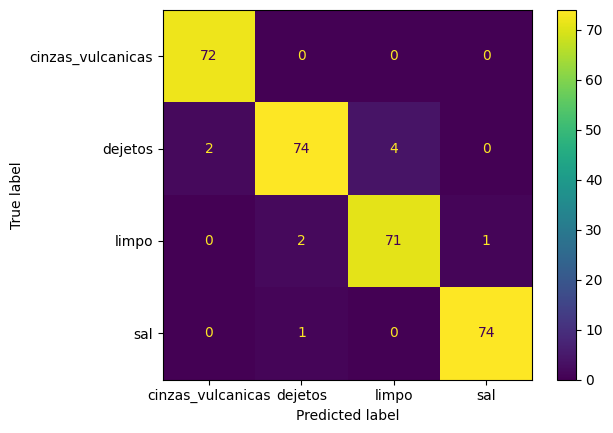

0.8737541528239202
0.8604651162790697
0.8837209302325582
0.8903654485049833


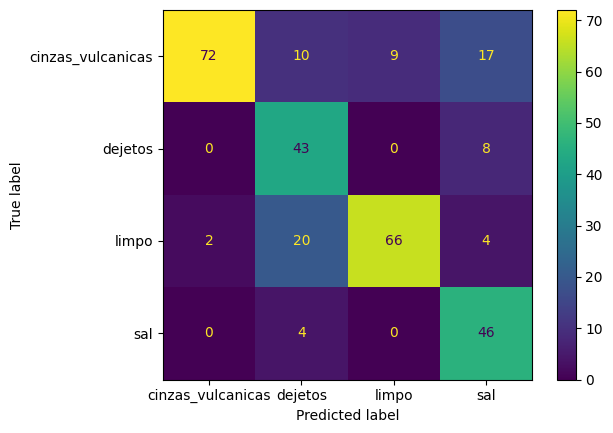

0.973421926910299
0.9435215946843853
0.9501661129568106
0.9800664451827242


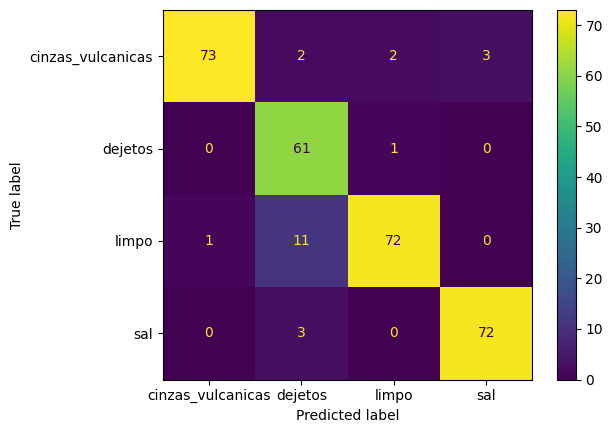

In [66]:
pred_models = []

evaluate = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

validation_dataset=evaluate.flow_from_directory('../dataset_dirty_insulator/test/', 
                                         target_size = (width_size, height_size), batch_size = batch_size,
                                         class_mode = 'categorical')


all_weights_models = ["../../neural_network/experimentos/unsup/dataset_inteiro/256/model_vgg16.hdf5",
                      "../../neural_network/experimentos/unsup/dataset_inteiro/256/model_resnet.hdf5",
                      "../../neural_network/experimentos/unsup/dataset_inteiro/256/model_custom.hdf5"]

for index_models in range(len(all_weights_models)):
    
    model = tf.keras.models.load_model(all_weights_models[index_models]) 
    pred_arrays = []

    for index in range(len(validation_dataset.filepaths)):
        #print(validation_dataset.filepaths[index])

        img = cv2.imread(validation_dataset.filepaths[index])

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        x = np.expand_dims(img, axis=0)
        images = np.vstack([x])

        pred_models.append(list(model.predict(images, batch_size=batch_size, verbose = 0)[0]))

        pred = list(model.predict(images, batch_size=batch_size, verbose = 0)[0])
        pred_arrays.append(pred.index(max(pred)))
        #print(pred)
        

    
    values = multilabel_confusion_matrix(pred_arrays, validation_dataset.classes)

    for index in range(len(values)):
        tp, fn = values[index][0]
        fp, tn = values[index][1]
        print(accuracy(tp, tn, fp, fn))

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_arrays, validation_dataset.classes), display_labels=validation_dataset.class_indices).plot()
    plt.show()

In [70]:
classes = ['cinzas_vulcanicas', 'dejetos', 'limpo', 'sal']

In [62]:
from sklearn.metrics import multilabel_confusion_matrix

values = multilabel_confusion_matrix(pred_arrays, validation_dataset.classes)

for index in range(len(values)):
    tp, fn = values[index][0]
    fp, tn = values[index][1]
    print(tp, tn, fp, fn)
    print(accuracy(tp, tn, fp, fn))

225 72 2 1
0.99
218 69 5 8
0.9566666666666667
218 69 7 6
0.9566666666666667
224 75 1 0
0.9966666666666667


In [61]:
values

array([[[225,   1],
        [  2,  72]],

       [[218,   8],
        [  5,  69]],

       [[218,   6],
        [  7,  69]],

       [[224,   0],
        [  1,  75]]])

In [58]:
tn, fp, fn, tp = values[0]

ValueError: not enough values to unpack (expected 4, got 2)

In [19]:
from sklearn.metrics import accuracy_score, precision_score

In [39]:
acc = accuracy_score(pred_arrays, validation_dataset.classes)
prec = precision_score(pred_arrays, validation_dataset.classes, average='macro')

print(acc, prec)

v= confusion_matrix(pred_arrays, validation_dataset.classes)

print(v[0])

0.95 0.9506013164917274
[72  1  1  0]


In [40]:
v

array([[72,  1,  1,  0],
       [ 0, 69,  5,  0],
       [ 1,  6, 69,  0],
       [ 0,  1,  0, 75]])

In [32]:
confusion_matrix?

In [30]:
values = confusion_matrix(pred_arrays, validation_dataset.classes, labels=[0, 1, 2, 3])

In [31]:

TP = values[0][0] = TP
values[1][1] = TN
values[0][1] = FP
values[1][0] = 

array([[72,  1,  1,  0],
       [ 0, 69,  5,  0],
       [ 1,  6, 69,  0],
       [ 0,  1,  0, 75]])

In [27]:
validation_dataset.class_indices

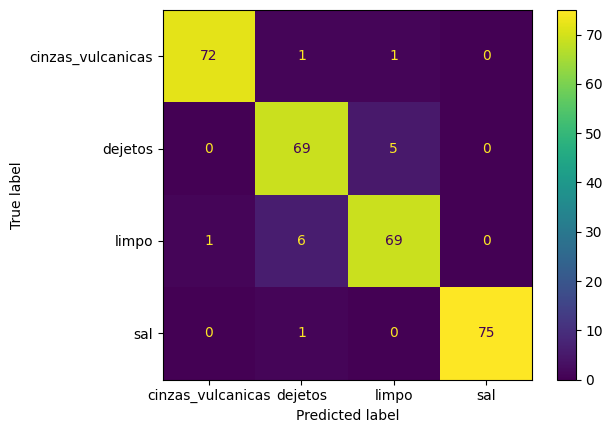

In [26]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_arrays, validation_dataset.classes), display_labels=validation_dataset.class_indices).plot()
plt.grid(False)
plt.show()

In [15]:
all_weights_models = ["model_vgg16.hdf5", "model_resnet.hdf5", "model_custom.hdf5"]

evaluate = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
validation_dataset=evaluate.flow_from_directory('./new_data/test/', 
                                         target_size = (width_size, height_size), batch_size = batch_size,
                                         class_mode = 'categorical')

for index in range(len(all_weights_models)):
    since = time.time()

    model = tf.keras.models.load_model(all_weights_models[index]) 
    
    scores = model.evaluate(trainGene, verbose=0)
    
    scores2 = model.evaluate(validation_dataset, verbose=0)

    time_elapsed = time.time() - since
    
    print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
    print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

    print(
        f"\n Total time: {round(time_elapsed // 60, 2)} minutes and {round(time_elapsed % 60, 2)} seconds \n"
    )


Found 292 images belonging to 4 classes.


KeyboardInterrupt: 

In [72]:
def plot_confusion_matrix(y_true: np.array, y_pred: np.array, classes: list, title: str ="Confusion Matrix", cmap: plt = plt.cm.Purples, save_as: str = "fig.png") -> plt.subplot:
        """Plot a consfusion matrix with all classes, considering the y_true and y_pred of the models 
        Args:
            y_true (np.array): True answers about the results
            y_pred (np.array): Prediction of the model
            classes (list): List with all the classes names
            title (str, optional): A text to be the title of plot. Defaults to "Confusion Matrix".
            cmap (plt, optional): Type of colors to fill the table. Defaults to plt.cm.Purples.
            save_as (str, optional): The name so save  the plots. Defaults to "fig.png".
        Returns:
            plt.subplot: Return a a subplot of confusion matrix, 
        """
        cm = confusion_matrix(y_true, y_pred)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True',
            xlabel='Predicted')

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], '.2f'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        fig.savefig(save_as)

        return ax


Found 301 images belonging to 4 classes.
0.9933554817275747
0.9700996677740864
0.9767441860465116
0.9933554817275747


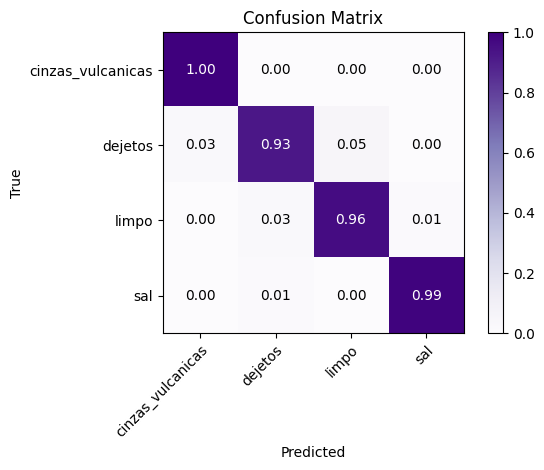

0.8737541528239202
0.8604651162790697
0.8837209302325582
0.8903654485049833


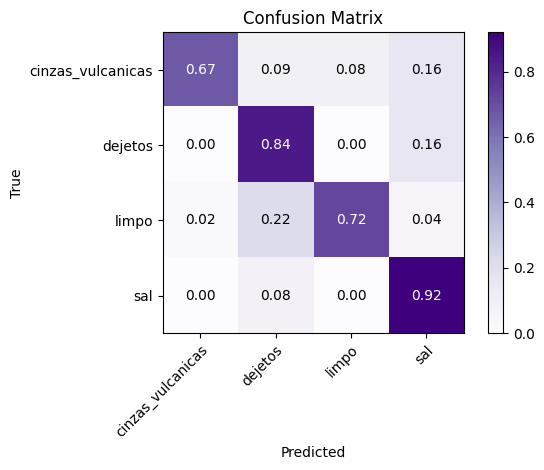

0.973421926910299
0.9435215946843853
0.9501661129568106
0.9800664451827242


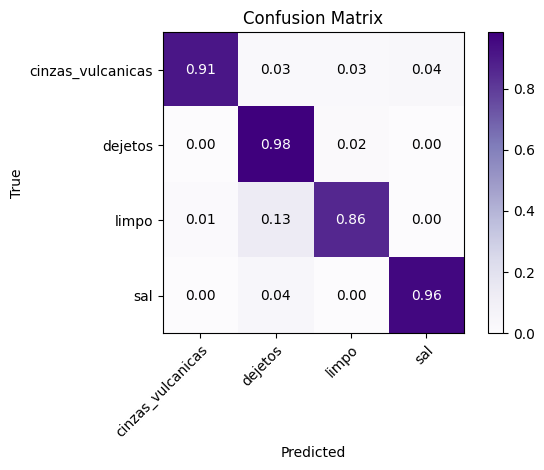

In [74]:
pred_models = []

evaluate = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

validation_dataset=evaluate.flow_from_directory('../dataset_dirty_insulator/test/', 
                                         target_size = (width_size, height_size), batch_size = batch_size,
                                         class_mode = 'categorical')


all_weights_models = ["../../neural_network/experimentos/unsup/dataset_inteiro/256/model_vgg16.hdf5",
                      "../../neural_network/experimentos/unsup/dataset_inteiro/256/model_resnet.hdf5",
                      "../../neural_network/experimentos/unsup/dataset_inteiro/256/model_custom.hdf5"]

for index_models in range(len(all_weights_models)):
    
    model = tf.keras.models.load_model(all_weights_models[index_models]) 
    pred_arrays = []

    for index in range(len(validation_dataset.filepaths)):
        #print(validation_dataset.filepaths[index])

        img = cv2.imread(validation_dataset.filepaths[index])

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        x = np.expand_dims(img, axis=0)
        images = np.vstack([x])

        pred_models.append(list(model.predict(images, batch_size=batch_size, verbose = 0)[0]))

        pred = list(model.predict(images, batch_size=batch_size, verbose = 0)[0])
        pred_arrays.append(pred.index(max(pred)))
        #print(pred)
        

    
    values = multilabel_confusion_matrix(pred_arrays, validation_dataset.classes)

    for index in range(len(values)):
        tp, fn = values[index][0]
        fp, tn = values[index][1]
        print(accuracy(tp, tn, fp, fn))

    #ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_arrays, validation_dataset.classes), display_labels=validation_dataset.class_indices).plot()
    plot_confusion_matrix(pred_arrays, validation_dataset.classes, classes)
    plt.show()